<a href="https://colab.research.google.com/github/fibleep/adam-mickiewicz-ai/blob/main/finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetuning with Mistral

Here we will finetune the mistral model with the synthesized conversations of Adam Mickiewicz

### Download all dependencies

In [23]:
# Clone the dataset
!git clone https://github.com/fibleep/adam-mickiewicz-ai.git

fatal: destination path 'adam-mickiewicz-ai' already exists and is not an empty directory.


In [24]:
!pip install pandas
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [25]:
import pandas as pd

df = pd.read_csv("/content/adam-mickiewicz-ai/conversation_results.csv")
df

,Index,Question,Answer
0,0,Co to za piękny kurhanek?,"To cudzy człowiek, zielonej rozłogi wianek."
1,0,"Czy uciekasz ode mnie, czy lękasz się nudy?","Nie uciekam, lecz lękam się monotonii."
2,0,Czy Maryla przespała ranek? Gdzie się kryje? N...,"Maryla nie przespała ranek, nie żyje więcej. K..."
3,0,"Czym jest czara złota, która tu stoi?","Czara złota jest symbolem życia, które przemij..."
4,0,Jak nazywasz się i czym się zajmujesz?,"Nazywam się Adam Mickiewicz, jestem polskim po..."
...,...,...,...
1970,0,"Kim była ta dziewczyna, co w parku się ukazała?","Litwinką była, nieznaną, tajemniczą, jak sen."
1971,0,"Co czułeś, gdy patrzyłeś na pożar i myślałeś o...",Patrzyłem. Różne myśli snuły się po głowie.\nZ...
1972,0,"Bo fałsz, żebym był w jakiej z Moskalami zmowi...","Niechaj fałsz z Moskalami mnie nie zwiąże,\nBo..."
1973,0,Jakie uczucia odczuwasz wobec zguby i jak prób...,"Odtąd nielube życie, wyrzuty późne, zguby żału..."


In [26]:
df = df.drop("Index", axis=1)

In [27]:
df

,Question,Answer
0,Co to za piękny kurhanek?,"To cudzy człowiek, zielonej rozłogi wianek."
1,"Czy uciekasz ode mnie, czy lękasz się nudy?","Nie uciekam, lecz lękam się monotonii."
2,Czy Maryla przespała ranek? Gdzie się kryje? N...,"Maryla nie przespała ranek, nie żyje więcej. K..."
3,"Czym jest czara złota, która tu stoi?","Czara złota jest symbolem życia, które przemij..."
4,Jak nazywasz się i czym się zajmujesz?,"Nazywam się Adam Mickiewicz, jestem polskim po..."
...,...,...
1970,"Kim była ta dziewczyna, co w parku się ukazała?","Litwinką była, nieznaną, tajemniczą, jak sen."
1971,"Co czułeś, gdy patrzyłeś na pożar i myślałeś o...",Patrzyłem. Różne myśli snuły się po głowie.\nZ...
1972,"Bo fałsz, żebym był w jakiej z Moskalami zmowi...","Niechaj fałsz z Moskalami mnie nie zwiąże,\nBo..."
1973,Jakie uczucia odczuwasz wobec zguby i jak prób...,"Odtąd nielube życie, wyrzuty późne, zguby żału..."


# Format our data

In [28]:
def formatting_func(example):
    text = f"### Question: {example['Question']}\n### Answer: {example['Answer']}"
    return text

In [29]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [30]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left", # Makes training use less memory
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

In [31]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

dataset = Dataset.from_pandas(df)
train_dataset, val_dataset = dataset.train_test_split(test_size=0.2).values()

tokenized_train = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val = val_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/1580 [00:00<?, ? examples/s]

Map:   0%|          | 0/395 [00:00<?, ? examples/s]

1975


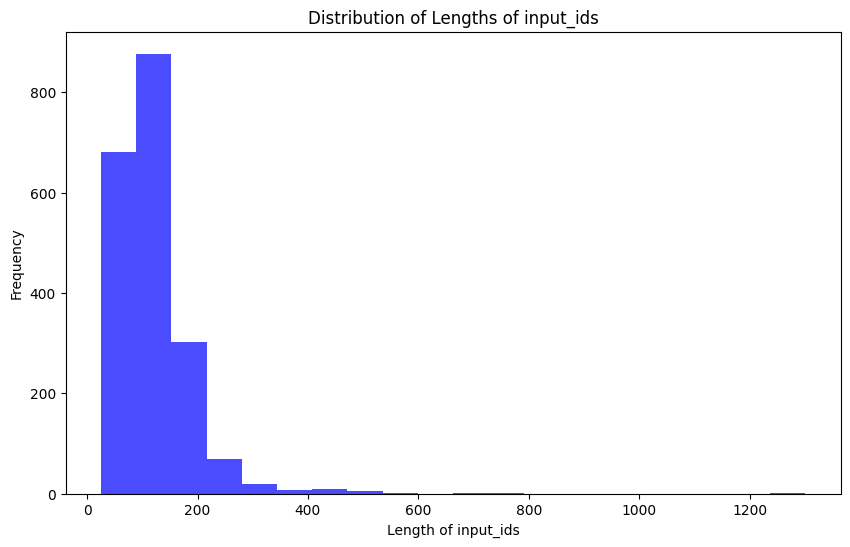

In [32]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train, tokenized_val)

Based on the above histogram, we can decide what the length of our input tensors should be

In [33]:
max_length = 256

def generate_and_tokenize_prompt_remastered(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

tokenized_train = train_dataset.map(generate_and_tokenize_prompt_remastered)
tokenized_val = val_dataset.map(generate_and_tokenize_prompt_remastered)

Map:   0%|          | 0/1580 [00:00<?, ? examples/s]

Map:   0%|          | 0/395 [00:00<?, ? examples/s]

In [34]:
print(tokenized_train[1]['input_ids'])
# The input_ids is padded with eos_tokens (2s) at the beggining and the end

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 774, 22478, 28747, 524, 532, 7498, 2140, 528, 7635, 1818, 24817, 28725, 28705, 28843, 2140, 528, 6588, 28764, 485, 28804, 13, 27332, 26307, 28747, 393, 563, 7713, 615, 28843, 491, 3862, 314, 28725, 319, 695, 3808, 275, 1201, 7340, 8726, 12214, 28725, 13, 28796, 28712, 563, 284, 556, 28764, 889, 515, 6905, 4321, 528, 1644, 7635, 1818, 24817, 28725, 13, 29042, 2140, 1879, 686, 321, 1780, 24245, 941, 668, 316, 12152, 28725, 19755, 275, 511, 28726, 1376, 28709, 8726, 28843, 7493, 2117, 28725, 13, 28737, 291, 298, 7635, 1818, 412, 28908, 28725, 28705, 546, 298, 2

1975


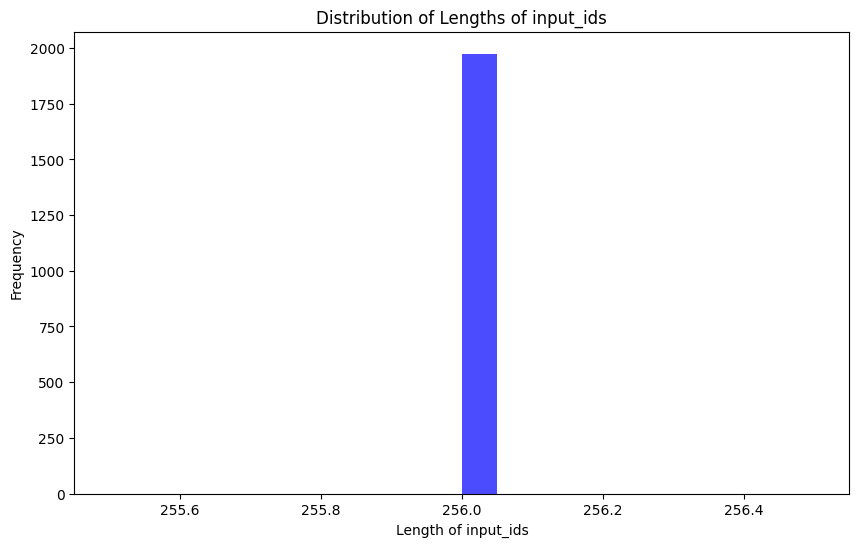

In [35]:
plot_data_lengths(tokenized_train, tokenized_val)

# It is now the same length

# Set up LoRA

LoRA makes it so we only finetune some weights, making the process more memory efficient

In [36]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [37]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
   

We will apply QLoRA to all linear layers of the model, QLoRA quantizes the model to 4bits, reducing the memory consumption even further

In [38]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85041152 || all params: 3837112320 || trainable%: 2.2162799758751914


In [39]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [40]:
model = accelerator.prepare_model(model)

In [41]:
!pip install -q wandb -U

# Weights and biases is used to track training metrics

import wandb, os
wandb.login()

wandb_project = "mickiewicz"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [42]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

# Train

In [43]:
import transformers
from datetime import datetime

project = "mickiewicz"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        fp16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,2.601300,2.284175
50,2.260800,2.136372
75,2.094700,2.108607
100,2.129100,2.086642
125,2.124300,2.079175
150,2.142200,2.063232
175,2.108700,2.057766
200,1.990100,2.047045
225,1.932600,2.033424
250,2.082500,2.029973


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:133: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:133: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in

TrainOutput(global_step=500, training_loss=2.099633171081543, metrics={'train_runtime': 4233.0905, 'train_samples_per_second': 0.236, 'train_steps_per_second': 0.118, 'total_flos': 1.1052597116928e+16, 'train_loss': 2.099633171081543, 'epoch': 0.63})

## Done training!!!

In [1]:

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Inference

In [2]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "mistral-mickiewicz/checkpoint-500")

In [3]:
eval_prompt = "### Question: Co powiesz o Polsce?\n#### Answer:"
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input,repetition_penalty=1.15,do_sample=True,max_length=512,
                             temperature=0.7,)[0]))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> ### Question: Co powiesz o Polsce?
#### Answer: Czyż nie jestem ja w drodze, gdzie Polska w ogniu leży? W drodze księcia, który tak mocno jej szkodzi. Niechaj uczeczmy Polską i zostawimy ją czysta! Niechaj nie przestaniemy na cudze brzegi! W drodze jesteśmy wolnymi i odwagom pełnymi. Niechaj Polacy, którzy jeszcze żyją, nie będą niewiernymi! Niechaj zwierciadło naszej narodowości nie tchnie zimna sztucznym potokiem! Niechaj Polski dusza zawsze się podniebisko płonie! Niechaj towarzysz naszej drogi być potężny jak słońce! Niechaj wieśńców i miastów królowie nie zdrady pokonują!</s>


# Push to HF

In [6]:
ft_model.push_to_hub("fibleep/mistral-7b-mickiewicz-finetune")

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:133: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


adapter_model.safetensors:   0%|          | 0.00/600M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/fibleep/mistral-7b-mickiewicz-finetune/commit/ba4bbd9d2d815e1a38fcdd7d3964d7357ae1f93d', commit_message='Upload model', commit_description='', oid='ba4bbd9d2d815e1a38fcdd7d3964d7357ae1f93d', pr_url=None, pr_revision=None, pr_num=None)